# GenAI Evaluation

In [67]:
import sys
import os
import pandas as pd
import requests
import json
import ast
from datetime import datetime
import itertools
from tqdm import tqdm
import re

from deepeval import evaluate
from deepeval.metrics import ContextualRelevancyMetric
from deepeval.test_case import LLMTestCase


import warnings
warnings.filterwarnings('ignore')

# Adjust the path to point to your root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(root_dir)

from buho_back.main import app
from buho_back.utils import ChatModel


user = "test_user"

app_url = "http://0.0.0.0:8080"
file_for_test = "file_for_test.pdf"
config_file_path = os.path.join("../buho_back/config.py")
questions_answers_for_test = pd.read_json("questions_answers_for_test.json")

chat_model = ChatModel()

# Upload files for test
file_path = os.path.join(os.getcwd(), file_for_test)

# Ensure the file is opened and closed properly
with open(file_path, "rb") as file:
    files = [("files", file)]
    
    # Reset the input files
    reset_response = requests.get(f"{app_url}/input_files/reset?user={user}")
    
    if reset_response.status_code == 200:
        # Upload the test file
        response_from_upload = requests.post(f"{app_url}/input_files/upload?user={user}", files=files)

        if response_from_upload.status_code == 200:
            print("Files uploaded successfully!")
        else:
            print(f"Error uploading files... Status Code: {response_from_upload.status_code}, Response: {response_from_upload.text}")
    else:
        print(f"Error resetting input files... Status Code: {reset_response.status_code}, Response: {reset_response.text}")

# create vectordb and summaries
response_from_process = requests.post(f"{app_url}/input_files/process?user={user}")

if response_from_upload.status_code == 200:
    print("Files processed successfully!")
else:
    print("Error uploading files...")

Files uploaded successfully!
Files processed successfully!


In [68]:
def ask_chat(question):
    body = {"question": question, "owner": user}
    
    response_from_ask = requests.post(
        f"{app_url}/chat/ask?user={user}", data=json.dumps(body)
    )
    try:
        answer_to_evaluate = response_from_ask.json()["answer"]
        sources = response_from_ask.json()["sources"]
        sources = [d.get('page_content','') for d in sources]
    except Exception as e:
        answer_to_evaluate = ""
        sources = []
        print(f"error: {e}")
    return [answer_to_evaluate, sources]


def evaluate_answer(question, expected_answer, answer_to_evaluate):
    prompt = f"""
        Evaluate if the answer given to a question is correct:
        1 means a correct answer
        0 means an incorrect answer

        Here's the question: {question}
        Here's the expected answer: {expected_answer}
        Here's the answer you need to evaluate: {answer_to_evaluate}

        Don't add any text to your response, just answer with a number (0 or 1).
    """
    evaluation = chat_model.invoke(prompt)
    return ast.literal_eval(evaluation)

def evaluate_sources(df):
    context_relevancy = []
    for _, row in df.iterrows():
        # Define metric
        metric = ContextualRelevancyMetric(
            threshold=0.5,
            model="gpt-3.5-turbo", #alternatively use "gpt-4"
        )

        # Define test case
        test_case = LLMTestCase(
            input = row.question,
            actual_output = row.answer,
            retrieval_context = row.sources,
        )

        # Calculate metric
        metric.measure(test_case)

        context_relevancy.append(metric.score)
    return context_relevancy

def update_hybrid_search_params(config_file_path: str, new_params: dict):
    # Convert the new_params dict to a string representation that matches Python syntax
    new_params_str = str(new_params)
    
    # Initialize a list to store lines
    updated_lines = []
    
    # Read the content of the config file line by line
    with open(config_file_path, "r") as file:
        for line in file:
            # If we find the line that starts with HYBRID_SEARCH_PARAMS, replace it with the new definition
            if line.strip().startswith("HYBRID_SEARCH_PARAMS"):
                updated_line = f"HYBRID_SEARCH_PARAMS = {new_params_str}\n"
                updated_lines.append(updated_line)
            else:
                updated_lines.append(line)
    
    # Write the updated lines back to the config file
    with open(config_file_path, "w") as file:
        file.writelines(updated_lines)


def run_all_tests(df):
    # get answers and sources
    df[["answer_to_evaluate", "sources"]] = df.apply(
        lambda row: ask_chat(row['question']),
        axis=1, result_type ='expand'
        )

    # evaluate sources
    df["sources_evaluation"] = evaluate_sources(df)

    # evaluate answers
    df["answer_evaluation"] = df.apply(
        lambda row: evaluate_answer(
            row['question'], row['answer'], row['answer_to_evaluate']
            ), axis=1).astype(int)
    
    return df

def export_results(df, param_combination):
    results = pd.DataFrame(df[["answer_evaluation", "sources_evaluation"]].mean()).T
    now = datetime.now().strftime("%Y%m%dT%H:%M:%S")
    parameters = pd.DataFrame(pd.Series(param_combination)).T
    parameters.insert(0, "timestamp", now)
    results = pd.concat([parameters, results], axis=1)
    
    pd.DataFrame(results).to_csv('genai_quality_log.csv', mode='a', header=False, index=False)

In [69]:
HYBRID_SEARCH_PARAMS = {
    'k_for_semantic_search': [5, 10, 20],
    'alpha_for_hybrid_search': [0.1, 0.5, 0.9],
    'k_for_hybrid_search': [1, 3, 5],
    'distance_threshold': [None, 0.9]
}

# HYBRID_SEARCH_PARAMS = {
#     'k_for_semantic_search': [5],
#     'alpha_for_hybrid_search': [0.1],
#     'k_for_hybrid_search': [1],
#     'distance_threshold': [0.1]
# }

# Get all the keys and values
keys = HYBRID_SEARCH_PARAMS.keys()
values = HYBRID_SEARCH_PARAMS.values()

# Generate all combinations using itertools.product
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

for param_combination in tqdm(combinations):
    update_hybrid_search_params(config_file_path, param_combination)
    results = run_all_tests(questions_answers_for_test)
    export_results(results, param_combination)

  0%|          | 0/54 [00:00<?, ?it/s]

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Event loop is already running. Applying nest_asyncio patch to allow async execution...

[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] HTTP Request: POST https://api.opena

In [70]:
# k_for_semantic_search 5.0
# alpha_for_hybrid_search 0.9
# k_for_hybrid_search 5.0
# distance_threshold 0.1

# Result evaluation

In [71]:
genai_quality_log = pd.read_csv("genai_quality_log.csv")
genai_quality_log

,timestamp,k_for_semantic_search,alpha_for_hybrid_search,k_for_hybrid_search,distance_threshold,answer_evaluation,sources_evaluation
0,20240823T09:55:42,5.0,0.1,1.0,NaN,0.800000,0.677778
1,20240823T09:59:19,5.0,0.1,1.0,0.9,0.900000,0.688889
2,20240823T10:02:58,5.0,0.1,3.0,NaN,0.833333,0.688889
3,20240823T10:07:05,5.0,0.1,3.0,0.9,0.900000,0.677778
4,20240823T10:10:36,5.0,0.1,5.0,NaN,0.900000,0.755556
5,20240823T10:14:54,5.0,0.1,5.0,0.9,0.933333,0.633333
6,20240823T10:18:08,5.0,0.5,1.0,NaN,0.800000,0.722222
7,20240823T10:21:32,5.0,0.5,1.0,0.9,0.866667,0.677778
8,20240823T10:25:38,5.0,0.5,3.0,NaN,0.833333,0.733333
9,20240823T10:29:28,5.0,0.5,3.0,0.9,0.866667,0.655556


In [72]:
def find_optimal_parameters(df):
    # Create new columns for sum and product of evaluations, and weighted sum
    df['sum_evaluations'] = df['answer_evaluation'] + df['sources_evaluation']
    df['product_evaluations'] = df['answer_evaluation'] * df['sources_evaluation']
    df['weighted_sum'] = 10 * df['answer_evaluation'] + df['sources_evaluation']
    
    # Find optimal parameters for each criterion
    optimal_answer = df.loc[df['answer_evaluation'].idxmax()]
    optimal_sources = df.loc[df['sources_evaluation'].idxmax()]
    optimal_sum = df.loc[df['sum_evaluations'].idxmax()]
    optimal_product = df.loc[df['product_evaluations'].idxmax()]
    optimal_weighted_sum = df.loc[df['weighted_sum'].idxmax()]

    # Store optimal parameters in a dictionary
    optimal_parameters = {
        'optimal_answer': optimal_answer,
        'optimal_sources': optimal_sources,
        'optimal_sum': optimal_sum,
        'optimal_product': optimal_product,
        'optimal_weighted_sum': optimal_weighted_sum
    }
    
    return optimal_parameters

find_optimal_parameters(genai_quality_log)

{'optimal_answer': timestamp                  20240823T10:14:54
 k_for_semantic_search                    5.0
 alpha_for_hybrid_search                  0.1
 k_for_hybrid_search                      5.0
 distance_threshold                       0.9
 answer_evaluation                   0.933333
 sources_evaluation                  0.633333
 sum_evaluations                     1.566667
 product_evaluations                 0.591111
 weighted_sum                        9.966667
 Name: 5, dtype: object,
 'optimal_sources': timestamp                  20240823T10:10:36
 k_for_semantic_search                    5.0
 alpha_for_hybrid_search                  0.1
 k_for_hybrid_search                      5.0
 distance_threshold                       NaN
 answer_evaluation                        0.9
 sources_evaluation                  0.755556
 sum_evaluations                     1.655556
 product_evaluations                     0.68
 weighted_sum                        9.755556
 Name: 4, dtype: o

In [73]:
genai_quality_log.sort_values(by="answer_evaluation", ascending=False)

,timestamp,k_for_semantic_search,alpha_for_hybrid_search,k_for_hybrid_search,distance_threshold,answer_evaluation,sources_evaluation,sum_evaluations,product_evaluations,weighted_sum
5,20240823T10:14:54,5.0,0.1,5.0,0.9,0.933333,0.633333,1.566667,0.591111,9.966667
16,20240823T10:59:26,5.0,0.9,5.0,NaN,0.900000,0.688889,1.588889,0.620000,9.688889
21,20240823T11:18:42,10.0,0.1,3.0,0.9,0.900000,0.633333,1.533333,0.570000,9.633333
3,20240823T10:07:05,5.0,0.1,3.0,0.9,0.900000,0.677778,1.577778,0.610000,9.677778
4,20240823T10:10:36,5.0,0.1,5.0,NaN,0.900000,0.755556,1.655556,0.680000,9.755556
38,20240823T12:21:27,20.0,0.1,3.0,NaN,0.900000,0.644444,1.544444,0.580000,9.644444
1,20240823T09:59:19,5.0,0.1,1.0,0.9,0.900000,0.688889,1.588889,0.620000,9.688889
17,20240823T11:03:35,5.0,0.9,5.0,0.9,0.900000,0.688889,1.588889,0.620000,9.688889
35,20240823T12:12:54,10.0,0.9,5.0,0.9,0.900000,0.722222,1.622222,0.650000,9.722222
18,20240823T11:07:22,10.0,0.1,1.0,NaN,0.866667,0.644444,1.511111,0.558519,9.311111


In [74]:
genai_quality_log.sort_values(by="sources_evaluation", ascending=False)

,timestamp,k_for_semantic_search,alpha_for_hybrid_search,k_for_hybrid_search,distance_threshold,answer_evaluation,sources_evaluation,sum_evaluations,product_evaluations,weighted_sum
4,20240823T10:10:36,5.0,0.1,5.0,NaN,0.900000,0.755556,1.655556,0.680000,9.755556
8,20240823T10:25:38,5.0,0.5,3.0,NaN,0.833333,0.733333,1.566667,0.611111,9.066667
26,20240823T11:37:42,10.0,0.5,3.0,NaN,0.800000,0.733333,1.533333,0.586667,8.733333
42,20240823T12:33:08,20.0,0.5,1.0,NaN,0.800000,0.722222,1.522222,0.577778,8.722222
6,20240823T10:18:08,5.0,0.5,1.0,NaN,0.800000,0.722222,1.522222,0.577778,8.722222
35,20240823T12:12:54,10.0,0.9,5.0,0.9,0.900000,0.722222,1.622222,0.650000,9.722222
50,20240823T12:55:07,20.0,0.9,3.0,NaN,0.833333,0.711111,1.544444,0.592593,9.044444
47,20240823T12:46:43,20.0,0.5,5.0,0.9,0.833333,0.711111,1.544444,0.592593,9.044444
13,20240823T10:46:43,5.0,0.9,1.0,0.9,0.833333,0.711111,1.544444,0.592593,9.044444
43,20240823T12:35:56,20.0,0.5,1.0,0.9,0.800000,0.711111,1.511111,0.568889,8.711111


In [75]:
genai_quality_log.sort_values(by=["answer_evaluation", "sources_evaluation"], ascending=False)

,timestamp,k_for_semantic_search,alpha_for_hybrid_search,k_for_hybrid_search,distance_threshold,answer_evaluation,sources_evaluation,sum_evaluations,product_evaluations,weighted_sum
5,20240823T10:14:54,5.0,0.1,5.0,0.9,0.933333,0.633333,1.566667,0.591111,9.966667
4,20240823T10:10:36,5.0,0.1,5.0,NaN,0.900000,0.755556,1.655556,0.680000,9.755556
35,20240823T12:12:54,10.0,0.9,5.0,0.9,0.900000,0.722222,1.622222,0.650000,9.722222
16,20240823T10:59:26,5.0,0.9,5.0,NaN,0.900000,0.688889,1.588889,0.620000,9.688889
17,20240823T11:03:35,5.0,0.9,5.0,0.9,0.900000,0.688889,1.588889,0.620000,9.688889
1,20240823T09:59:19,5.0,0.1,1.0,0.9,0.900000,0.688889,1.588889,0.620000,9.688889
3,20240823T10:07:05,5.0,0.1,3.0,0.9,0.900000,0.677778,1.577778,0.610000,9.677778
38,20240823T12:21:27,20.0,0.1,3.0,NaN,0.900000,0.644444,1.544444,0.580000,9.644444
21,20240823T11:18:42,10.0,0.1,3.0,0.9,0.900000,0.633333,1.533333,0.570000,9.633333
15,20240823T10:55:41,5.0,0.9,3.0,0.9,0.866667,0.700000,1.566667,0.606667,9.366667


In [76]:
genai_quality_log.sort_values(by="sum_evaluations", ascending=False)

,timestamp,k_for_semantic_search,alpha_for_hybrid_search,k_for_hybrid_search,distance_threshold,answer_evaluation,sources_evaluation,sum_evaluations,product_evaluations,weighted_sum
4,20240823T10:10:36,5.0,0.1,5.0,NaN,0.900000,0.755556,1.655556,0.680000,9.755556
35,20240823T12:12:54,10.0,0.9,5.0,0.9,0.900000,0.722222,1.622222,0.650000,9.722222
17,20240823T11:03:35,5.0,0.9,5.0,0.9,0.900000,0.688889,1.588889,0.620000,9.688889
16,20240823T10:59:26,5.0,0.9,5.0,NaN,0.900000,0.688889,1.588889,0.620000,9.688889
1,20240823T09:59:19,5.0,0.1,1.0,0.9,0.900000,0.688889,1.588889,0.620000,9.688889
3,20240823T10:07:05,5.0,0.1,3.0,0.9,0.900000,0.677778,1.577778,0.610000,9.677778
30,20240823T11:56:05,10.0,0.9,1.0,NaN,0.866667,0.700000,1.566667,0.606667,9.366667
52,20240823T13:00:47,20.0,0.9,5.0,NaN,0.866667,0.700000,1.566667,0.606667,9.366667
5,20240823T10:14:54,5.0,0.1,5.0,0.9,0.933333,0.633333,1.566667,0.591111,9.966667
8,20240823T10:25:38,5.0,0.5,3.0,NaN,0.833333,0.733333,1.566667,0.611111,9.066667


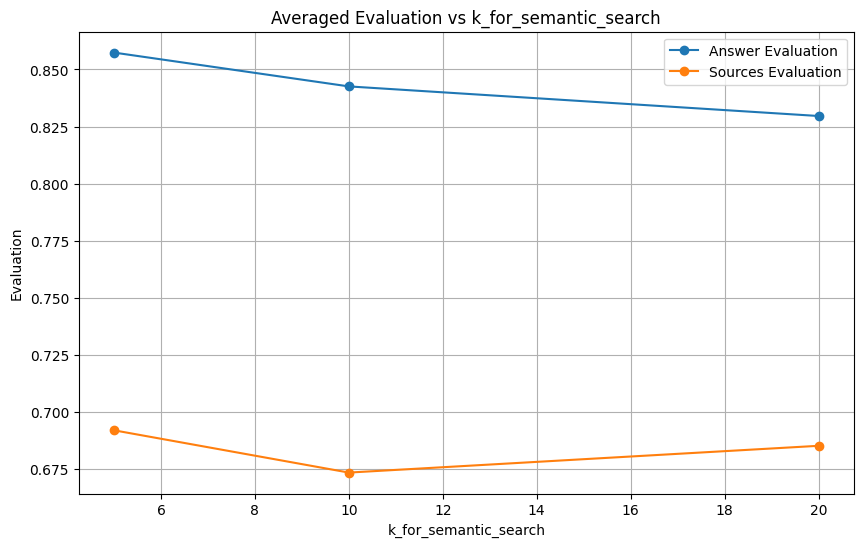

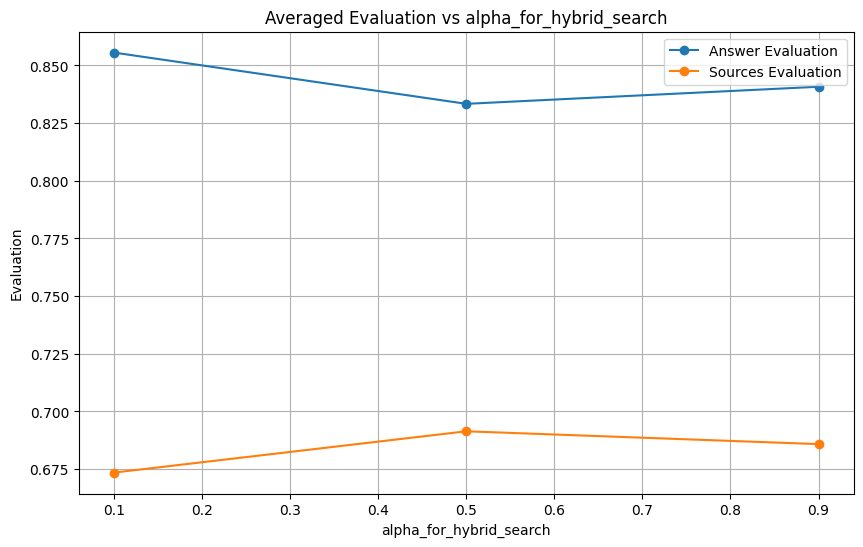

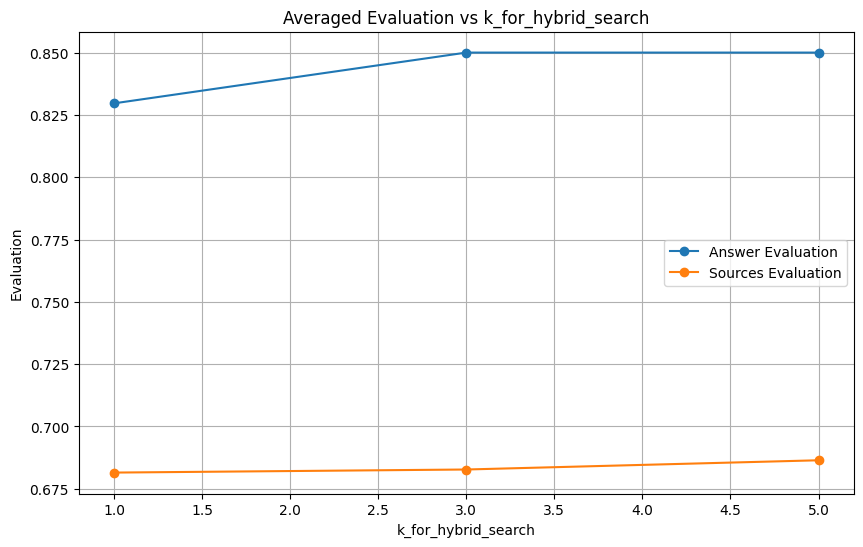

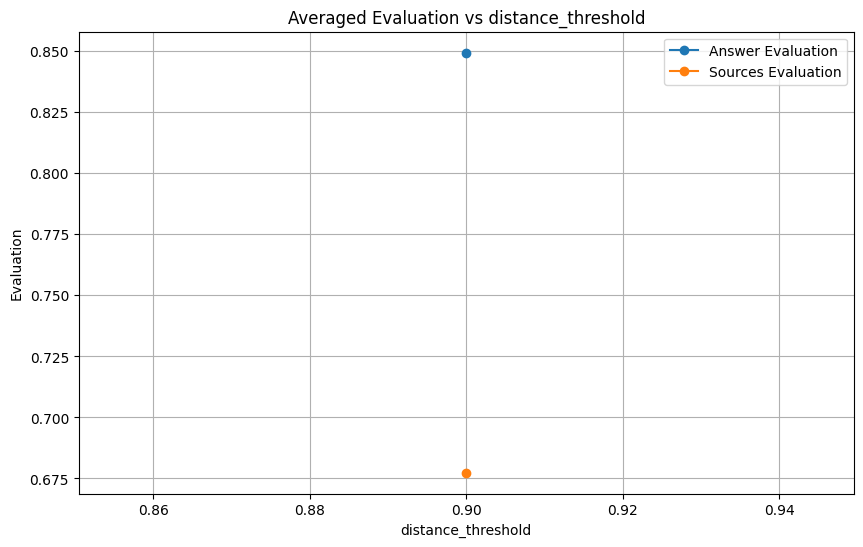

In [77]:
import matplotlib.pyplot as plt

def plot_averaged_evaluations(df):
    # Parameters to analyze
    parameters = ['k_for_semantic_search', 'alpha_for_hybrid_search', 'k_for_hybrid_search', 'distance_threshold']
    evaluation_metrics = ["answer_evaluation", "sources_evaluation"]
    
    for param in parameters:
        # Group by the parameter and calculate the mean for evaluations
        grouped = df.groupby(param)[evaluation_metrics].mean().reset_index()
        
        # Calculate average evaluation for the grouped data
        
        # Plotting the evaluations
        plt.figure(figsize=(10, 6))
        plt.plot(grouped[param], grouped['answer_evaluation'], label='Answer Evaluation', marker='o')
        plt.plot(grouped[param], grouped['sources_evaluation'], label='Sources Evaluation', marker='o')
        plt.xlabel(param)
        plt.ylabel('Evaluation')
        plt.title(f'Averaged Evaluation vs {param}')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_averaged_evaluations(genai_quality_log)

In [80]:
genai_quality_log.fillna(0).groupby("distance_threshold")[["answer_evaluation", "sources_evaluation"]].mean()

,answer_evaluation,sources_evaluation
distance_threshold,,
0.0,0.837037,0.689712
0.9,0.849383,0.677366


In [81]:
genai_quality_log[["answer_evaluation", "sources_evaluation"]].max()

answer_evaluation     0.933333
sources_evaluation    0.755556
dtype: float64